In [19]:
import os
import re
import sys
import string
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter


import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub



from pathlib import Path
from transformers import BertTokenizerFast, TFBertModel
from sklearn.model_selection import train_test_split as tts


In [2]:
text_dir = "../data/raw/text"
labels_dir =  "../data/raw/labels"
audio_dir = "../data/raw/audio"



## Nettoyage, traitement etc
Surtout utilisé pour prétraitement, mais une partie utile pour inférence de nouvelles données

In [3]:
#On va chercher tout les fichiers textes dans le répertoire
text_files = glob.glob(f"{text_dir}/*.txt")

## Chaque ligne de texte est precede d'un "stamp" qui indique le clip de l'enregistrement etc
def remove_stamps_str(line)->str:
    stamp = re.search('.+___', line).group(0)
    new_line = line.strip(stamp)
    return new_line


## Pour python < 3.9, sinon str.removeprefix() de base
## Fonctioon juste utile sur ma machine locale
def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]


Génération d'une liste de textes avec leur ID pour les identifier dans dataframe.
Utilisation de Generator pour vitesse/mémoire

In [4]:


def text_list_generator(files_list, text_dir):
    text_list = []
    for filename in files_list:
        with open(file = filename, encoding = 'utf-8') as f:

            ##WINDOWS SPECIFIC
            if sys.platform == 'win32':
                videoid = removeprefix(filename, text_dir + '\\').rstrip('.txt')
            else :
                videoid = removeprefix(filename, text_dir + '/').rstrip('.txt')
            lines = f.readlines()
            for line_number, text_line in enumerate(lines):
                clean_line = remove_stamps_str(text_line)
                clip_id = videoid +'_'+ text_line.split('___')[1]
                #clip_id = videoid +'_' +str(line_number)
                yield (clip_id, clean_line.rstrip())


Simple traitement du texte.
Avec l'utilisation d'un Tokenizer pré-entrainé lié à BERT, il est inutile de retirer les stopwords ou de lemmatiser, donc on s'assure surtout de retirer les charactères problématiques

In [5]:
#Retire tous les timestamps en début de ligne, présents dans chaque transcript
def remove_stamps_str(line)->str:
    stamp = re.search('.+___', line).group(0)
    new_line = line.strip(stamp)
    return new_line

#Retire les charactères non-ascii 
def remove_nonascii(line)->str:
    ascii_line = line.encode(encoding = 'ascii', errors = 'ignore').decode()
    return ascii_line

#met tout en minuscules, retire les nombres
def clean_punct_digits(line)->str:
    new_line = line.translate(str.maketrans('', '', string.punctuation))
    new_line = ' '.join([word.lower() for word in new_line.split() if (len(word) >=2 and word.isalpha())])
    return new_line



# DF des labels

In [6]:
label_df = pd.read_csv("../data/interim/labels/interim.csv")
display(label_df)

,id,anger,disgust,fear,happiness,sadness,surprise,sentiment
0,--qXJuDtHPw_5,0,0,0,1,0,0,1
1,-3g5yACwYnA_10,0,0,0,0,0,0,1
2,-3g5yACwYnA_13,0,0,0,0,0,0,1
3,-3g5yACwYnA_2,0,0,0,1,0,0,0
4,-3g5yACwYnA_3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
21860,zwTrXwi54us_6,0,0,0,0,0,0,0
21861,zwTrXwi54us_7,0,0,0,0,0,0,0
21862,zwTrXwi54us_8,0,0,0,0,0,0,0
21863,zwTrXwi54us_9,0,0,0,0,0,0,1


# Données texte

À partir des fichiers .txt, génère un dataframe qui contient une entrée pour chaque ligne de texte

In [7]:
corpus = (text for text in text_list_generator(text_files, text_dir))
df_text = pd.DataFrame(corpus)
df_text.columns = ['id', 'text']

In [8]:
display(df_text.head(5))

,id,text
0,--qXJuDtHPw_0,I see that there are three category of writers.
1,--qXJuDtHPw_1,"I define them as being an author, a writer, an..."
2,--qXJuDtHPw_2,"An author, I like to classify as somebody who ..."
3,--qXJuDtHPw_3,These are the well-known authors of our time a...
4,--qXJuDtHPw_4,"Then, there is the writer."


Comme le texte contient des charactères non-conformes (non ascii, autres langues etc), et de la mauvaise ponctuation,
on nettoie chaque entrée en retirant ponctuation, nombres et non-ascii.

In [9]:
df_text['text'] =  df_text.text.apply(remove_nonascii)
df_text['clean_text'] = df_text.text.apply(lambda s : clean_punct_digits(s))

display(df_text.head(3))

,id,text,clean_text
0,--qXJuDtHPw_0,I see that there are three category of writers.,see that there are three category of writers
1,--qXJuDtHPw_1,"I define them as being an author, a writer, an...",define them as being an author writer and stor...
2,--qXJuDtHPw_2,"An author, I like to classify as somebody who ...",an author like to classify as somebody who wri...


In [10]:
frame = pd.merge(df_text, label_df, on = 'id', how = 'inner')
display(frame.head(3))


,id,text,clean_text,anger,disgust,fear,happiness,sadness,surprise,sentiment
0,--qXJuDtHPw_5,I see that a writer is somebody who has an inc...,see that writer is somebody who has an incredi...,0,0,0,1,0,0,1
1,-3g5yACwYnA_2,Key Polymer brings a technical aspect to our o...,key polymer brings technical aspect to our ope...,0,0,0,1,0,0,0
2,-3g5yACwYnA_3,We're a huge user of adhesives for our operati...,were huge user of adhesives for our operation ...,0,0,0,0,0,0,0


Création d'un nouveau dataframe, "new polarity", pour n'utiliser que le texte nettoyé et la polarité du sentiment, de 0 pour négatif à 2 pour positif.

In [11]:
new_polarity_df = frame.copy()
new_polarity_df.drop(columns=['id', 'text','anger', 'disgust','fear','happiness','sadness', 'surprise'], inplace= True)
#Originalement, les valeurs sont de -1 à 1 mais modèle ne peut utiliser des valeurs négatives comme ça
new_polarity_df.sentiment = new_polarity_df.sentiment.apply(lambda x : x+1)
display(new_polarity_df.head(3))


,clean_text,sentiment
0,see that writer is somebody who has an incredi...,2
1,key polymer brings technical aspect to our ope...,1
2,were huge user of adhesives for our operation ...,1


Quelques NAN qui block calculs dont on drop

In [12]:
#new_polarity_df = pd.read_csv('./polarity.csv')

new_polarity_df.dropna(inplace=True)

In [14]:
display(new_polarity_df.sentiment.value_counts())



1    7552
2    5102
0    2923
Name: sentiment, dtype: int64

Les données ne sont pas très bien balancées, mais la performance est bonne quand même. Comme on veut que ce soit "réaliste", et qu'il s'agit du plus gros dataset, on assume que c'est une représentation adéquate.


### Modèle Tensorflow et BERT

Le modèle pré-entraîné BERT utilisé ici est très lourd, et HEROKU n'accepte que des petits fichiers et n'a pas beaucoup de mémoire vive.
Cette version du modèle est donc seulement à rouler en local. 

Le model utilisé par l'application, (et selui dans 'models/text_model.py') est donc un modèle bidon.

In [28]:


MAX_LEN = 128

#Le modele pre entraine BERT est utilise sous forme dun HubLayer 
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
BERT_LAYER = hub.KerasLayer(module_url, trainable=False)
#Tokenizer qui prend les strings propres et calcul les embeddings
TOKENIZER = BertTokenizerFast.from_pretrained('bert-base-uncased')


#Quelques metriques intéressantes
#Bien que F1_score serait interessant, KERAS  ne le fourni pas car ce nest pas une bonne metrique calculee par batch
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall')
]

#Encodes lists of texts into BERT-useable tensors
def bert_encode(texts, tokenizer=TOKENIZER, max_len=MAX_LEN):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


#Building a neural-net that uses BERT embeddings
def build_model(bert_layer=BERT_LAYER, max_len=MAX_LEN):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]

    net = tf.keras.layers.Dense(16, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.9)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08), loss='categorical_crossentropy', metrics=METRICS)
    
    return model


def train_dnn(model, X_train, y_train, e=4):
    #checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

    train_input = bert_encode(X_train)
    train_labels = y_train

    train_history = model.fit(
            train_input, train_labels, 
            validation_split=0.2,
            epochs=e,
            callbacks=[ earlystopping],
            batch_size=64,
            verbose=1
            )
    return train_history


    
data = new_polarity_df
x = data.clean_text.values
dummy_sents = pd.get_dummies(data.sentiment)
y = dummy_sents.values
X_train, X_test, y_train, y_test = tts(x, y, test_size = 0.1)
model = build_model()




In [29]:
histo = train_dnn(model, X_test, y_test)

Epoch 1/3
20/20 [==============================] - 27s 1s/step - loss: 1.8349 - accuracy: 0.3756 - precision: 0.3170 - recall: 0.1509 - val_loss: 1.3874 - val_accuracy: 0.2179 - val_precision: 0.2346 - val_recall: 0.0609
Epoch 2/3
20/20 [==============================] - 20s 996ms/step - loss: 1.7822 - accuracy: 0.3804 - precision: 0.3043 - recall: 0.1429 - val_loss: 1.3307 - val_accuracy: 0.2308 - val_precision: 0.2031 - val_recall: 0.0417
Epoch 3/3
20/20 [==============================] - 20s 994ms/step - loss: 1.5897 - accuracy: 0.3973 - precision: 0.3261 - recall: 0.1332 - val_loss: 1.2802 - val_accuracy: 0.2340 - val_precision: 0.2000 - val_recall: 0.0256


In [30]:
import matplotlib.pyplot as plt 

Le KERNEL a crash et dû être reset avec VSCode, donc doit retrain au complet.
Prend >3h à train sur machine sans GPU, donc utilisé un plus petit model pour les images suivantes.

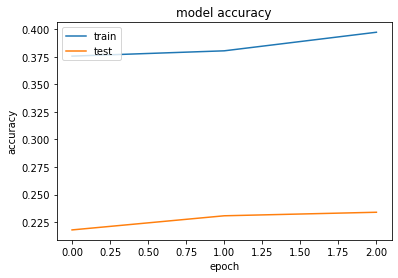

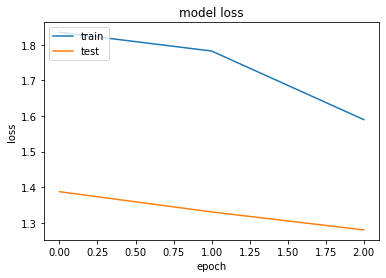

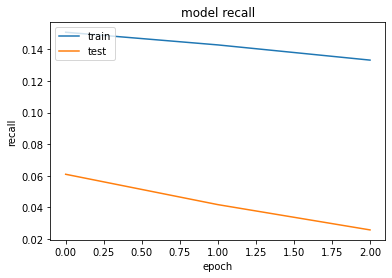

In [33]:
# summarize history for accuracy
plt.plot(histo.history['accuracy'])
plt.plot(histo.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(histo.history['recall'])
plt.plot(histo.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(Images si on roule le modèle avec paramètres originaux)
On remarque un certain overfit à dès la 2e époque, la VAL_ACCURACY diminue légèrement alors que training accuracy augmente un peu, et val_loss augmente de la 2e à la 3e epoch, mais c'est peut-être random.

Les autres métriques, comme val_recall et val_precision ont cependant très légèrement augmenté de la 1ere à la 3e époque.

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Pour générer nouvelle matrice, j'ai utilisé predictions sur ensemble de test (pas celui utilisé pour validation)

In [35]:

#On encode le texte (x_test) avec l'encodeur BERT pour avoir les embeddings/masks etc.
preds = model.predict(bert_encode(X_test))

#Comme le modèle donne des probabilités pour chaque classe, on prend le Argmax pour avoir la bonne classe.
y_test_true = pd.Series([np.argmax(y) for y in y_test])
#Idem pour vraie prédictions
true_preds = [np.argmax(x) for x in preds]

49/49 [==============================] - 21s 413ms/step


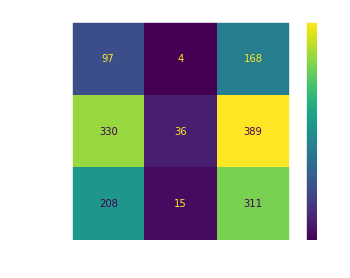

In [36]:
#Axes et écriture en blanc pour voir sur fond noir
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

ConfusionMatrixDisplay.from_predictions(y_test_true, true_preds, display_labels = ['negative', 'neutral', 'positive'])
plt.title('Text model predictions', color='white')
plt.show()

VRAIE MATRICE DE CONFUSION DANS LES DIAPOS

On voit que la classe la mieux prédite est "neutral", avec un petit biais pour "positive" dans les erreurs.
Ceci est peut-être dû au fait que les données sont un peu biaisées, mais nous voulions avoir le plus de données possible et les métriques n'étaient pas trop affectées.